In [8]:
import pandas as pd

# Sample classes
classes = ['a', 'b', 'c', 'd']

# Create a pandas DataFrame with the classes
df = pd.DataFrame({'class': classes})

# Use get_dummies() function to one-hot encode the classes
one_hot_encoded = pd.get_dummies(df['class'])

print("One-hot encoded classes:")
print(one_hot_encoded)


One-hot encoded classes:
       a      b      c      d
0   True  False  False  False
1  False   True  False  False
2  False  False   True  False
3  False  False  False   True


In [1]:
import torch
import logging as log
from model.micn import MICN
from utils.timefeature import time_features

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device(f"cuda:0")
    log.info("GPU Available. Using GPU[%d]: %s", 0, torch.cuda.get_device_name(0))
else:
    log.info("No GPU available. Using CPU.")


def eval_model(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    a = checkpoint['params']['args']
    model = MICN(in_features=a.in_features, out_features=a.out_features,
                 seq_len=a.seq_len, pred_len=a.pred_len, num_hidden=a.num_hidden,
                 mic_layers=a.mic_layers, dropout=a.dropout, freq=a.freq, device=device,
                 decomp_kernel=a.decomp_kernel, conv_kernel=a.conv_kernel,
                 isometric_kernel=a.isometric_kernel).float().to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    return checkpoint['params'], model.eval()


params, model = eval_model('micn.pth')

In [2]:
mean, std = params['mean'], params['std']

In [3]:
import pandas as pd

df = pd.read_excel(r'.\datasets\diabetes_datasets\Shanghai_T2DM\2093_0_20201109.xls')
df = df.iloc[100:600 + 96, :2]
lst = df.values.tolist()

In [4]:
ll = [[l[0].strftime('%Y-%m-%d %X'), l[1]] for l in lst]

In [5]:
new = [[pd.to_datetime(l[0], format='%Y-%m-%d %X'), l[1]] for l in ll]

In [7]:
ll[0:96]

[['2020-11-10 11:55:00', 156.6],
 ['2020-11-10 12:10:00', 183.6],
 ['2020-11-10 12:25:00', 167.4],
 ['2020-11-10 12:40:00', 135.0],
 ['2020-11-10 12:55:00', 115.2],
 ['2020-11-10 13:10:00', 104.4],
 ['2020-11-10 13:25:00', 102.6],
 ['2020-11-10 13:40:00', 113.4],
 ['2020-11-10 13:55:00', 129.6],
 ['2020-11-10 14:10:00', 144.0],
 ['2020-11-10 14:25:00', 156.6],
 ['2020-11-10 14:40:00', 167.4],
 ['2020-11-10 14:55:00', 174.6],
 ['2020-11-10 15:10:00', 178.2],
 ['2020-11-10 15:25:00', 176.4],
 ['2020-11-10 15:40:00', 165.6],
 ['2020-11-10 15:55:00', 156.6],
 ['2020-11-10 16:10:00', 149.4],
 ['2020-11-10 16:25:00', 138.6],
 ['2020-11-10 16:40:00', 131.4],
 ['2020-11-10 16:55:00', 138.6],
 ['2020-11-10 17:10:00', 131.4],
 ['2020-11-10 17:25:00', 118.8],
 ['2020-11-10 17:40:00', 118.8],
 ['2020-11-10 17:55:00', 127.8],
 ['2020-11-10 18:10:00', 129.6],
 ['2020-11-10 18:25:00', 129.6],
 ['2020-11-10 18:40:00', 138.6],
 ['2020-11-10 18:55:00', 169.2],
 ['2020-11-10 19:10:00', 203.4],
 ['2020-11

In [22]:
rst = []
for i in range(500):
    date = []
    ot = []
    for elem in new[i:i + 96]:
        date.append(elem[0])
        ot.append(elem[1])
    ot = (ot - mean) / std
    for i in range(32):
        date.append(date[-1] + pd.offsets.Minute(15))
    ipt = pd.DataFrame(date, columns=['date'])
    time_stamp = time_features(ipt, freq='min')
    data = torch.Tensor(ot).reshape([1, 96, 1]).float().to(device)
    mark = torch.from_numpy(time_stamp).reshape([1, 128, 5]).float().to(device)
    pred = model(data, mark)
    rst.append(pred.reshape(-1, )[0].item())
rst = rst * std + mean

In [23]:
y = [i[1] for i in new][96:]

In [24]:
%matplotlib inline

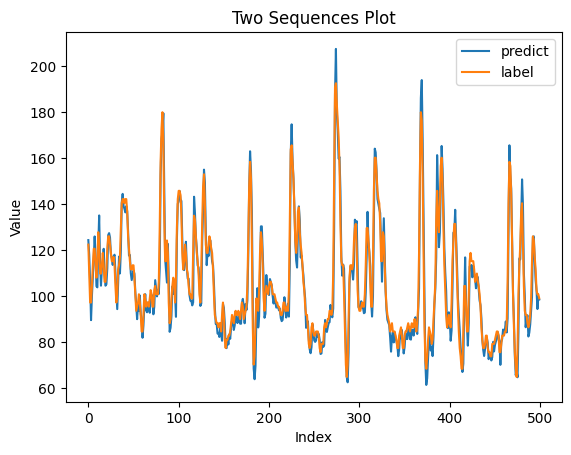

In [25]:
import matplotlib.pyplot as plt

# Create a line plot for each sequence
plt.plot(rst, label="predict")
plt.plot(y, label="label")

# Add labels and title
plt.xlabel("Index")
plt.ylabel("Value")
plt.title("Two Sequences Plot")

# Add legend
plt.legend()

# Show the plot
plt.show()
